#### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

import tools
from skimage import transform


In [10]:
all_images = []
all_categories = []

datasetX = []
datasetY = []

image_size = (200, 200)

def load_datasets(img, category, file_name):
    if category == "PNEUMONIA":
        if "virus" in file_name:
            category = "VIRUS PNEUMONIA"
        elif "bacteria" in file_name:
            category = "BACTERIA PNEUMONIA"
    else:
        category = "NORMAL"
    
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

tools.browse_imgs_multi_classes(load_datasets)

##### Doubler le dataset d'images NORMAL

In [11]:
def rotate_image(image, angle):
    return transform.rotate(image, angle)

def flip_image(image):
    return image[:, ::-1]

normal_indice = []
print("Normal indices size : ", len(normal_indice))

# Créer une liste pour stocker les indices des images "NORMAL"
normal_indice = [i for i, category in enumerate(all_categories) if category == "NORMAL"]

print("Normal indices size : ", len(normal_indice))

# Pour chaque image "NORMAL"...
for i in normal_indice:
    img = all_images[i]

    # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
    rotated_img = rotate_image(img, 20)
    resized_rotated_img = cv2.resize(rotated_img, image_size)
    all_images.append(resized_rotated_img)
    all_categories.append("NORMAL")

    # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
    flipped_img = flip_image(img)
    resized_flipped_img = cv2.resize(flipped_img, image_size)
    all_images.append(resized_flipped_img)
    all_categories.append("NORMAL")

# Convert the list of all images to a numpy array
datasetX = np.array(all_images)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)

Normal indices size :  0
Normal indices size :  1583
Dataset all shape :  (9022, 200, 200)


#### Doubler le datase d'images "virus pneumonia"

In [12]:
# Créer une liste pour stocker les indices des images "VIRUS PNEUMONIA"
virus_pneumonia_indices = [i for i, category in enumerate(all_categories) if category == "VIRUS PNEUMONIA"]

print("VIRUS PNEUMONIA indices size : ", len(virus_pneumonia_indices))

# Pour chaque image "VIRUS PNEUMONIA"...
for i in virus_pneumonia_indices:
    img = all_images[i]

    # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
    rotated_img = rotate_image(img, 20)
    resized_rotated_img = cv2.resize(rotated_img, image_size)
    all_images.append(resized_rotated_img)
    all_categories.append("VIRUS PNEUMONIA")

    # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
    flipped_img = flip_image(img)
    resized_flipped_img = cv2.resize(flipped_img, image_size)
    all_images.append(resized_flipped_img)
    all_categories.append("VIRUS PNEUMONIA")

# Convertir la liste de toutes les images en un tableau numpy
datasetX = np.array(all_images)
datasetY = np.array(all_categories)  # Assurez-vous que cette conversion est nécessaire pour votre cas d'utilisation

print("Dataset all shape : ", datasetX.shape)

VIRUS PNEUMONIA indices size :  1493
Dataset all shape :  (12008, 200, 200)


#### CNN - Convolution Neural Network

##### Les imports

In [13]:
import visualkeras as vk
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

##### Le modèle

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [14]:
num_classes = 3
core_size = 8
model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(16, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# model.summary()

In [15]:
model.compile(optimizer='rmsprop',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
datasetX = np.array(all_images)
datasetY = np.array(all_categories)

xtrain, otherX, ytrain, otherY = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xval, testx, yval, testy = train_test_split(otherX, otherY, test_size=0.5, random_state=1)

xtrain = xtrain / 255
testx = testx / 255
xval = xval / 255

label_to_index = {"NORMAL": 0, "VIRUS PNEUMONIA": 1, "BACTERIA PNEUMONIA": 2}
ytrain = np.array([label_to_index[y] for y in ytrain])
testy = np.array([label_to_index[y] for y in testy])
yval = np.array([label_to_index[y] for y in yval])

random_indices = np.random.choice(ytrain.shape[0], 20, replace=False)
print(ytrain[random_indices])

model.fit(xtrain,
    ytrain,
    validation_data=(xval, yval),
    epochs=10)

[0 1 2 0 1 1 0 2 2 2 0 0 0 1 2 2 1 0 2 0]
Epoch 1/10


c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


301/301 ━━━━━━━━━━━━━━━━━━━━ 73s 239ms/step - accuracy: 0.3906 - loss: 1.0376 - val_accuracy: 0.6003 - val_loss: 0.7525
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 71s 235ms/step - accuracy: 0.6020 - loss: 0.7835 - val_accuracy: 0.5420 - val_loss: 0.8645
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 68s 227ms/step - accuracy: 0.6716 - loss: 0.6718 - val_accuracy: 0.6919 - val_loss: 0.5978
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 71s 235ms/step - accuracy: 0.7075 - loss: 0.5550 - val_accuracy: 0.7002 - val_loss: 0.5737
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - accuracy: 0.7219 - loss: 0.5316 - val_accuracy: 0.6994 - val_loss: 0.5873
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 56s 185ms/step - accuracy: 0.7486 - loss: 0.5070 - val_accuracy: 0.7161 - val_loss: 0.6093
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 56s 187ms/step - accuracy: 0.7475 - loss: 0.4802 - val_accuracy: 0.7377 - val_loss: 0.5348
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - accuracy: 0.7527 - loss: 0.4655 - val

In [17]:
print(model.evaluate(testx, testy))

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.7299 - loss: 0.4918
[0.48860689997673035, 0.731890082359314]


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step


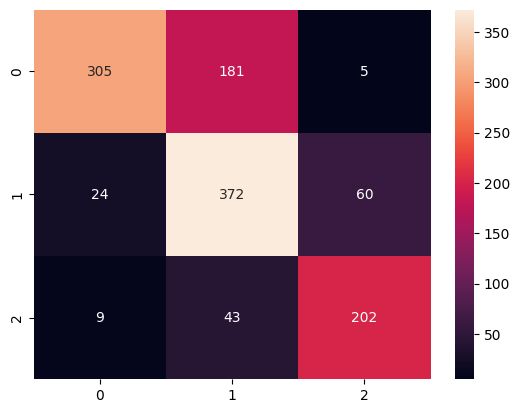

[[305 181   5]
 [ 24 372  60]
 [  9  43 202]]
recall :  0.744082108988172
precision :  0.7610274149489779
f1score :  0.7394941643826822


In [18]:
y_pred = model.predict(testx)

y_pred_label = np.argmax(y_pred, axis=1)

cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label, average='macro')  # Ajout de average='macro' pour multi-classe
precision = precision_score(testy, y_pred_label, average='macro')
f1score = f1_score(testy, y_pred_label, average='macro')
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

#### Classification Report

In [86]:
from sklearn.metrics import classification_report

# Assuming y_pred_label contains the predicted class labels as shown in your code
labels = ['NORMAL', 'VIRUS PNEUMONIA', 'BACTERIA PNEUMONIA']

# Generate the classification report using the true labels and predicted labels
report = classification_report(testy, y_pred_label, target_names=labels)

print(report)

                    precision    recall  f1-score   support

            NORMAL       0.98      0.94      0.96       483
   VIRUS PNEUMONIA       0.61      0.56      0.58       145
BACTERIA PNEUMONIA       0.77      0.85      0.81       275

          accuracy                           0.85       903
         macro avg       0.79      0.79      0.79       903
      weighted avg       0.86      0.85      0.85       903

